# Retrieval model using TFRS on Amazon Electronics

## Setup

In [ ]:
!pip install tensorflow-recommenders

In [ ]:
import os
import pprint
import tempfile
from typing import Dict, Text
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs

## Data

In [ ]:
!wget -q --show-progress http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Electronics.csv

ratings_Electronics 100%[===================>] 304.00M  4.01MB/s    in 42s     

2021-12-13 07:26:48 (7.25 MB/s) - ‘ratings_Electronics.csv’ saved [318766497/318766497]



In [ ]:
df = pd.read_csv('ratings_Electronics.csv', names=['userId', 'productId','Rating','timestamp'])
df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
df.dropna(inplace=True)
df.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   Rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 298.5+ MB


In [ ]:
print('Minimum rating is: %d' %(df.Rating.min()))
print('Maximum rating is: %d' %(df.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


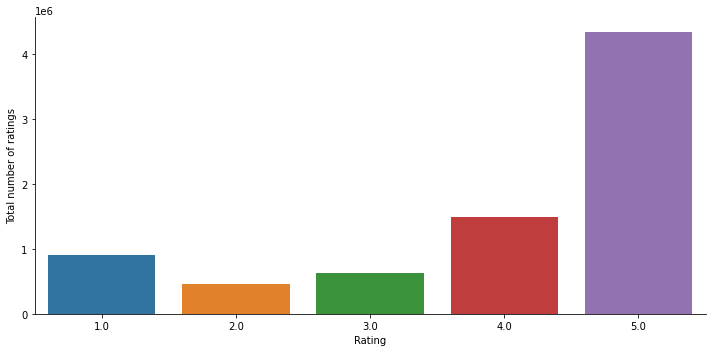

In [ ]:
g = sns.catplot(x="Rating", data=df, aspect=2.0, kind='count')
g.set_ylabels("Total number of ratings")
plt.show()

In [ ]:
df.drop(['timestamp'], axis=1, inplace=True)

num_of_rated_products_per_user = df.groupby(by='userId')['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: Rating, dtype: int64

In [ ]:
new_df = df.sample(frac=0.1).groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [ ]:
new_df.describe(include='all')

,userId,productId,Rating
count,225497,225497,225497.000000
unique,213764,1945,NaN
top,A680RUE1FDO8B,B0074BW614,NaN
freq,12,1804,NaN
mean,NaN,NaN,4.172645
std,NaN,NaN,1.288490
min,NaN,NaN,1.000000
25%,NaN,NaN,4.000000
50%,NaN,NaN,5.000000
75%,NaN,NaN,5.000000


In [ ]:
df = new_df.copy()
interactions_dict = df.drop(['Rating'],axis=1)
interactions_dict = {name: np.array(value) for name, value in interactions_dict.items()}
interactions = tf.data.Dataset.from_tensor_slices(interactions_dict)

items_dict = df[['productId']].drop_duplicates()
items_dict = {name: np.array(value) for name, value in items_dict.items()}
items = tf.data.Dataset.from_tensor_slices(items_dict)

interactions = interactions.map(lambda x: {
    'userId' : x['userId'], 
    'productId' : x['productId'], 
})

items = items.map(lambda x: x['productId'])

### get unique item and user id's as a lookup table
unique_item_titles = np.unique(np.concatenate(list(items.batch(1000))))
unique_user_ids = np.unique(np.concatenate(list(interactions.batch(1_000).map(lambda x: x["userId"]))))

# Randomly shuffle data and split between train and test.
tf.random.set_seed(42)
shuffled = interactions.shuffle(200_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(180_000)
test = shuffled.skip(180_000).take(20_000)

## Model

In [ ]:
class RetailModel(tfrs.Model):

    def __init__(self, user_model, item_model):
        super().__init__()
        
        ### Candidate model (item)
        ### This is Keras preprocessing layers to first convert user ids to integers, 
        ### and then convert those to user embeddings via an Embedding layer. 
        ### We use the list of unique user ids we computed earlier as a vocabulary:
        item_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_item_titles, mask_token=None),
                                        tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                        ])
        ### we pass the embedding layer into item model
        self.item_model: tf.keras.Model = item_model
            
        ### Query model (users)    
        user_model = tf.keras.Sequential([
                                        tf.keras.layers.experimental.preprocessing.StringLookup(
                                        vocabulary=unique_user_ids, mask_token=None),
                                        # We add an additional embedding to account for unknown tokens.
                                        tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                        ])
        self.user_model: tf.keras.Model = user_model
        ### for retrieval model. we take top-k accuracy as metrics
        metrics = tfrs.metrics.FactorizedTopK(
                                            candidates=items.batch(128).map(item_model))
        
        # define the task, which is retrieval                                    )    
        task = tfrs.tasks.Retrieval(
                                    metrics=metrics
                                    )
       
        self.task: tf.keras.layers.Layer = task

    def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
        # We pick out the user features and pass them into the user model.
        user_embeddings = self.user_model(features["userId"])
        # And pick out the movie features and pass them into the movie model,
        # getting embeddings back.
        positive_movie_embeddings = self.item_model(features["productId"])

        # The task computes the loss and the metrics.
        return self.task(user_embeddings, positive_movie_embeddings)

## Training and Evaluation

In [ ]:
### we choose the dimensionality of the query and candicate representation.
embedding_dimension = 32

## we pass the model, which is the same model we created in the query and candidate tower, into the model
item_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_item_titles, mask_token=None),
                                tf.keras.layers.Embedding(len(unique_item_titles) + 1, embedding_dimension)
                                ])

user_model = tf.keras.Sequential([
                                tf.keras.layers.experimental.preprocessing.StringLookup(
                                vocabulary=unique_user_ids, mask_token=None),
                                # We add an additional embedding to account for unknown tokens.
                                tf.keras.layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                                ])

model = RetailModel(user_model, item_model)

# a smaller learning rate may make the model move slower and prone to overfitting, so we stick to 0.1
# other optimizers, such as SGD and Adam, are listed here https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

## fit the model with ten epochs
model_hist = model.fit(cached_train, epochs=10)

#evaluate the model
model.evaluate(cached_test, return_dict=True)

Epoch 1/10
22/22 [==============================] - 60s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0012 - factorized_top_k/top_5_categorical_accuracy: 0.0075 - factorized_top_k/top_10_categorical_accuracy: 0.0128 - factorized_top_k/top_50_categorical_accuracy: 0.0439 - factorized_top_k/top_100_categorical_accuracy: 0.0751 - loss: 73623.2249 - regularization_loss: 0.0000e+00 - total_loss: 73623.2249
Epoch 2/10
22/22 [==============================] - 58s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.1562 - factorized_top_k/top_5_categorical_accuracy: 0.3927 - factorized_top_k/top_10_categorical_accuracy: 0.4832 - factorized_top_k/top_50_categorical_accuracy: 0.7217 - factorized_top_k/top_100_categorical_accuracy: 0.8168 - loss: 72300.0727 - regularization_loss: 0.0000e+00 - total_loss: 72300.0727
Epoch 3/10
22/22 [==============================] - 57s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.3928 - factorized_top_k/top_5_categorical_accuracy: 0.8

{'factorized_top_k/top_100_categorical_accuracy': 0.04984999820590019,
 'factorized_top_k/top_10_categorical_accuracy': 0.005450000055134296,
 'factorized_top_k/top_1_categorical_accuracy': 0.0001500000071246177,
 'factorized_top_k/top_50_categorical_accuracy': 0.02565000019967556,
 'factorized_top_k/top_5_categorical_accuracy': 0.0026000000070780516,
 'loss': 31409.376953125,
 'regularization_loss': 0,
 'total_loss': 31409.376953125}

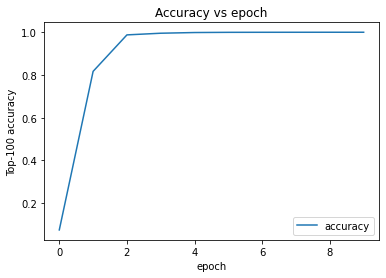

In [ ]:
# num_validation_runs = len(one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [i for i in range(10)]

plt.plot(epochs, model_hist.history["factorized_top_k/top_100_categorical_accuracy"], label="accuracy")
plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

## Inference

In [ ]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)

# recommends products out of the entire product dataset.
index.index(items.batch(100).map(model.item_model), items)

# Get recommendations.
j = str(20)
_, titles = index(tf.constant([j]))
print(f"Recommendations for user %s: {titles[0]}" %(j))

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-13 07:52:48

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython                : 5.5.0
tensorflow_recommenders: 0.6.0
seaborn                : 0.11.2
pandas                 : 1.1.5
numpy                  : 1.19.5
matplotlib             : 3.2.2
tensorflow             : 2.7.0



---

**END**